<a href="https://colab.research.google.com/github/adimalhotra11/CryptoPricePrediction/blob/master/crypto_ETH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [39]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=ETH&tsym=USD&limit=1000')


In [40]:
df = pd.DataFrame(json.loads(res.content)['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
target_col = 'close'

In [41]:
df.head(5)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2019-01-31,108.79,105.77,108.52,2030539.26,2.161672e+08,106.46,multiply,BTC
2019-02-01,107.62,105.55,106.46,1698659.24,1.812844e+08,106.72,multiply,BTC
2019-02-02,110.80,107.93,106.72,1615356.38,1.785914e+08,110.56,multiply,BTC
2019-02-03,109.11,106.56,110.56,1882567.19,2.015132e+08,107.04,multiply,BTC
2019-02-04,107.54,105.92,107.04,2060237.91,2.196391e+08,106.61,multiply,BTC


In [42]:
df.tail(10)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2021-10-18,3894.27,3677.52,3846.66,361513.63,1.365253e+09,3746.14,direct,
2021-10-19,3888.54,3733.60,3746.14,291414.08,1.110236e+09,3877.45,direct,
2021-10-20,4168.74,3829.95,3877.45,427521.45,1.719887e+09,4162.49,direct,
2021-10-21,4373.21,4015.24,4162.49,585122.78,2.439960e+09,4062.76,direct,
2021-10-22,4168.19,3892.38,4062.76,365507.01,1.474775e+09,3971.95,direct,
2021-10-23,4171.67,3937.93,3971.95,206808.72,8.397662e+08,4168.96,direct,
2021-10-24,4185.96,3963.11,4168.96,222789.38,9.041141e+08,4082.08,direct,
2021-10-25,4235.57,4069.68,4082.08,273786.47,1.140018e+09,4220.26,direct,
2021-10-26,4295.04,4094.55,4220.26,307683.57,1.291728e+09,4129.95,direct,


### I have to get rid of conversionType and conversionSymbol as they are not required.

In [43]:
df = df.drop(["conversionType", "conversionSymbol"], axis = 'columns')


In [44]:
df.head(20)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2019-01-31,108.79,105.77,108.52,2030539.26,2.161672e+08,106.46
2019-02-01,107.62,105.55,106.46,1698659.24,1.812844e+08,106.72
2019-02-02,110.80,107.93,106.72,1615356.38,1.785914e+08,110.56
2019-02-03,109.11,106.56,110.56,1882567.19,2.015132e+08,107.04
2019-02-04,107.54,105.92,107.04,2060237.91,2.196391e+08,106.61
2019-02-05,107.33,106.29,106.61,1814712.94,1.933888e+08,106.57
2019-02-06,105.11,101.78,106.57,2082286.07,2.170930e+08,104.26
2019-02-07,104.57,103.42,104.26,1843678.58,1.911713e+08,103.69
2019-02-08,120.60,112.03,103.69,2722369.81,3.246257e+08,119.24


In [45]:
df.describe()

,high,low,open,volumefrom,volumeto,close
count,1001.000000,1001.000000,1001.000000,1.001000e+03,1.001000e+03,1001.000000
mean,943.288671,871.308731,908.274535,1.673760e+06,7.648759e+08,912.133167
std,1157.504744,1062.719551,1111.972293,1.374391e+06,8.072272e+08,1115.888957
min,104.570000,101.780000,103.690000,1.354761e+05,3.759109e+07,103.690000
25%,183.340000,177.500000,180.400000,5.479167e+05,3.021591e+08,180.720000
50%,273.230000,261.900000,265.940000,1.290504e+06,5.059884e+08,267.500000
75%,1721.690000,1549.080000,1651.480000,2.457223e+06,9.440188e+08,1667.220000
max,4379.790000,4094.550000,4220.260000,1.098033e+07,9.657969e+09,4220.260000


In [46]:
print("Our data starts from:",df.index[0],"and ends at(updated today): ", df.index[-1])

Our data starts from: 2019-01-31 00:00:00 and ends at(updated today):  2021-10-27 00:00:00


In [47]:
def box_plot(x1,label1=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [48]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [49]:
train, test = train_test_split(df, test_size=0.2)

In [50]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

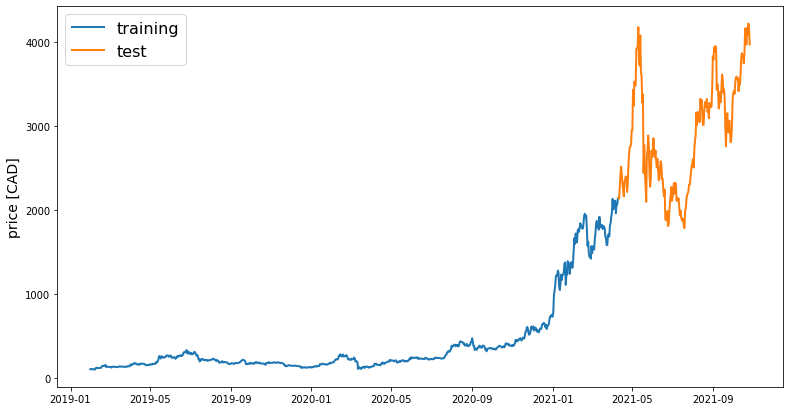

In [51]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [52]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [53]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [54]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [55]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [56]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 50
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [57]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [58]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
25/25 [==============================] - 2s 25ms/step - loss: 0.0095 - val_loss: 0.0076
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 0.0065
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0047 - val_loss: 0.0059
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0043 - val_loss: 0.0053
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0049
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 8/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0034 - val_loss: 0.0045
Epoch 9/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 10/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 11/50
25/25 

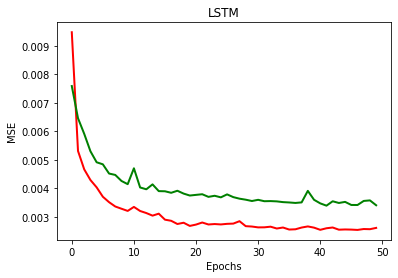

In [59]:
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [60]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mae = mean_absolute_error(preds, y_test)


In [61]:
print("mean absolute error:",mae)

mean absolute error: 0.044533147373224904


In [62]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(preds, y_test)



In [63]:
print("mean squared error:",MSE)

mean squared error: 0.0034058715529387148


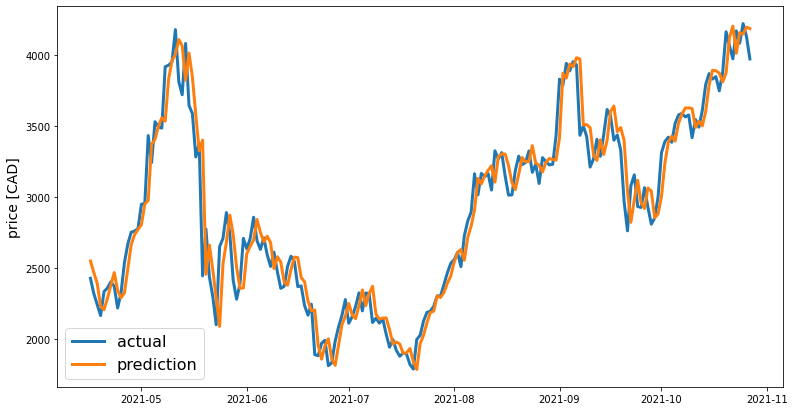

In [64]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)